In [12]:
import cv2
import numpy as np
def preprocess_captcha(image_path, character_color):
    # Load the captcha image
    captcha = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(captcha, cv2.COLOR_BGR2GRAY)

    # Create a mask for the character color region
    mask = cv2.inRange(gray, character_color, character_color)

    # Set the character region to black
    captcha[mask > 0] = (0, 0, 0)  # Set all channels to black (0, 0, 0)

    # Set the background region to white
    captcha[mask == 0] = (255, 255, 255)  # Set all channels to white (255, 255, 255)

    return captcha

# Example usage
image_path = 'captchas/bdHBnp.png'
character_color = 102  # Adjust this value to match the character color (hex: #666666)

result = preprocess_captcha(image_path, character_color)

# Display the preprocessed image
cv2.imshow("Preprocessed Image", result)
cv2.waitKey(0)


-1

In [16]:
# To make sure that i have collected all the characters.
import os

chars = {}
letters = "abcdefghijklmnopqrstuvwxyz"
for i in letters:
    chars[i] = 0

for i in letters.upper():
    chars[i] = 0

for i in range(10):
    chars[str(i)] = 0

image_names = os.listdir("./captchas")

for image_name in image_names:
    characters = image_name[:-4]
    if len(characters)==6:
        for c in characters:
            chars[c] += 1

for i in chars:
    if chars[i]==0:
        print(i)

print("I guess these characters never appear, as it is ambiguous")

i
l
o
q
I
O
Q
0
1
I guess these characters never appear, as it is ambiguous


In [17]:
"0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ".find("z")

35

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input shape of your captcha images
input_shape = (160, 75, 1)  # Assuming grayscale captcha images, adjust the channel value if using RGB images

# Define the character set
characters = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
num_characters = len(characters)

# Define the maximum length of the captcha sequence
max_sequence_length = 6

# Define the scale factor for mapping output values to the desired range
scale_factor = num_characters - 1  # Scale factor to map values from 0 to 1 to the range of 0 to num_characters-1

# Define the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(max_sequence_length, activation='relu')
])

# Scale the output values to the desired range
model.add(layers.Lambda(lambda x: scale_factor * tf.nn.relu(x)))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 73, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 17, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41344)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [78]:
# Augmentation with preprocessing images
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the paths for the input and output directories
input_dir = './captchas'
output_dir = './preprocessed_captchas'

# Set up the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation between -10 and +10 degrees
    width_shift_range=0.1,  # Random horizontal shift by 10% of the image width
    height_shift_range=0.1,  # Random vertical shift by 10% of the image height
    shear_range=0.2,  # Apply shear transformation with a maximum shear of 20%
    zoom_range=0.2,  # Randomly zoom in or out by 20%
    fill_mode='constant',  # Fill any empty pixels with constant value (e.g., black)
    cval=255  # Set the constant value to white (255)
)

# Iterate over the images in the input directory
for filename in os.listdir(input_dir):
    # Read the image
    image_path = os.path.join(input_dir, filename)
    image = cv2.imread(image_path)
    
    # Preprocess the image
    preprocessed_image = preprocess_captcha(image_path, character_color)
    
    # Expand dimensions to match the expected input shape of the model
    # preprocessed_image = np.expand_dims(preprocessed_image, axis=-1)
    
    # Create a directory for the current image in the output directory
    output_subdir = os.path.join(output_dir, os.path.splitext(filename)[0])
    if not os.path.exists(output_subdir):
        os.makedirs(output_subdir)
    
    # Generate augmented images and save them in the output directory
    for i, batch in enumerate(datagen.flow(np.array([preprocessed_image]), batch_size=1)):
        augmented_image = batch[0].astype(np.uint8)
        
        # Save the augmented image
        output_filename = f'{os.path.splitext(filename)[0]}_{i}.png'
        output_path = os.path.join(output_subdir, output_filename)
        cv2.imwrite(output_path, augmented_image)
        
        # Break the loop after generating a desired number of augmented images
        if i == 99:
            break


In [68]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input shape of your captcha images
input_shape = (160, 75, 1)  # Assuming grayscale captcha images, adjust the channel value if using RGB images

# Define the character set
characters = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
num_characters = len(characters)

# Define the maximum length of the captcha sequence
max_sequence_length = 6

# Define the scale factor for mapping output values to the desired range
scale_factor = num_characters - 1  # Scale factor to map values from 0 to 1 to the range of 0 to num_characters-1

# Define the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(max_sequence_length * num_characters, activation='relu'),
    layers.Reshape((max_sequence_length, num_characters))
])

# Scale the output values to the desired range
model.add(layers.Lambda(lambda x: scale_factor * tf.nn.relu(x)))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 158, 73, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 79, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 77, 34, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 38, 17, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 41344)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [102]:
from tensorflow import keras
from tensorflow.keras import layers

# Set the paths for the preprocessed images
images_dir = 'preprocessed_captchas'


# Define the characters for mapping labels
characters = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"


# Function to convert labels to list form
def convert_label_to_list(label):
    label_list = []
    for char in label:
        index = characters.index(char)
        oh = [0]*62
        oh[index] = 1
        label_list.append(oh)
    return label_list

# Load the preprocessed images and labels
X = []
y = []
for subdir, dirs, files in os.walk(images_dir):
    for file in files:
        # Load the image
        image_path = os.path.join(subdir, file)
        image = keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=input_shape[:2])
        image = keras.preprocessing.image.img_to_array(image)
        image /= 255.0
        X.append(image)
        
        # Extract the label from the file name
        label = file.split('.')[0][:6]
        label_list = convert_label_to_list(label)
        y.append(label_list)

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)


In [103]:
# Split the data into training and validation sets
validation_split = 0.2
split_index = int(len(X) * (1 - validation_split))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Convert the labels to one-hot encoding
num_classes = len(characters)
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_val = keras.utils.to_categorical(y_val, num_classes)

# Train the model
batch_size = 32
epochs = 10
# model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))


In [135]:
X_train.shape

(4010, 160, 75, 1)

In [117]:
y_train.shape

(4010, 6, 62)

In [134]:
y_train.shape

(4010, 6, 62)

In [124]:
y_val.shape

(1003, 6, 62)

In [116]:
model.output_shape

(None, 6, 62)

In [107]:
log_dir = "logs"  # Specify the directory path for logs

In [108]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [128]:
model.fit(X_train, y_train.reshape(4010,6,62), batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val.reshape(1003,6,62)), callbacks=[tensorboard_callback])

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "D:\anaconda\envs\captcha\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\anaconda\envs\captcha\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\anaconda\envs\captcha\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\anaconda\envs\captcha\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "D:\anaconda\envs\captcha\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "D:\anaconda\envs\captcha\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "D:\anaconda\envs\captcha\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "D:\anaconda\envs\captcha\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "D:\anaconda\envs\captcha\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\anaconda\envs\captcha\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "D:\anaconda\envs\captcha\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "D:\anaconda\envs\captcha\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "D:\anaconda\envs\captcha\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "D:\anaconda\envs\captcha\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\anaconda\envs\captcha\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\anaconda\envs\captcha\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "D:\anaconda\envs\captcha\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "D:\anaconda\envs\captcha\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\anaconda\envs\captcha\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\anaconda\envs\captcha\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\anaconda\envs\captcha\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Lakshman Kishore\AppData\Local\Temp\ipykernel_20848\1240435430.py", line 1, in <module>
      model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "D:\anaconda\envs\captcha\lib\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [192,62] and labels shape [11904]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_23069]

In [35]:
from tensorboard import program
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', log_dir])
url = tb.launch()
print(f"TensorBoard is running at {url}")

TensorBoard is running at http://localhost:6006/


In [36]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  0


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [7]:
!tensorboard dev upload --logdir \
    'logs'

^C


In [27]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [30]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate a specific amount of GPU memory
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


In [32]:
gpus

[]

In [168]:
timage = keras.preprocessing.image.load_img("./preprocessed_captchas/8sxnXu/8sxnXu_1.png", color_mode='grayscale', target_size=input_shape[:2])
timage = keras.preprocessing.image.img_to_array(timage)

In [169]:
timage/=255

In [170]:
timage = np.array(timage)

In [171]:
timage.shape

(160, 75, 1)

In [172]:
X_train[0].shape

(160, 75, 1)

In [173]:
result.shape

(75, 160, 3)

In [177]:
image = keras.preprocessing.image.load_img("./preprocessed_captchas/HuayFn/HuayFn_1.png", color_mode='grayscale', target_size=input_shape[:2])
image = keras.preprocessing.image.img_to_array(image)
image /= 255.0

print(image.shape)
image = np.array([image])

(160, 75, 1)


In [178]:
predictions = model.predict([image])

1/1 [==============================] - 0s 216ms/step


In [179]:
predictions.shape

(1, 6, 62)

In [41]:

# Get the predicted labels
predicted_labels = tf.argmax(tf.squeeze(predictions), axis=-1)

# Convert the predicted labels to characters
characters = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
predicted_characters = [characters[label] for label in predicted_labels]

# Print the predicted characters
print(predicted_characters)

['0', 'u', 'a', 'y', 'F', 'n']


In [188]:
predicted_labels

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 0, 30, 10, 34, 41, 23], dtype=int64)>

In [189]:
# Use GPU for training

In [190]:
predictions.shape

(1, 6, 62)

In [191]:
tf.argmax(predictions[0], axis=-1)

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([10,  7, 43, 29, 40, 36], dtype=int64)>

## Keras OCR Testing

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [56]:
# Path to the data directory
data_dir = Path("./captchas/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print("Max length",max_length)

Number of images found:  50
Number of labels found:  50
Number of unique characters:  53
Characters present:  ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Max length 6


In [57]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [58]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

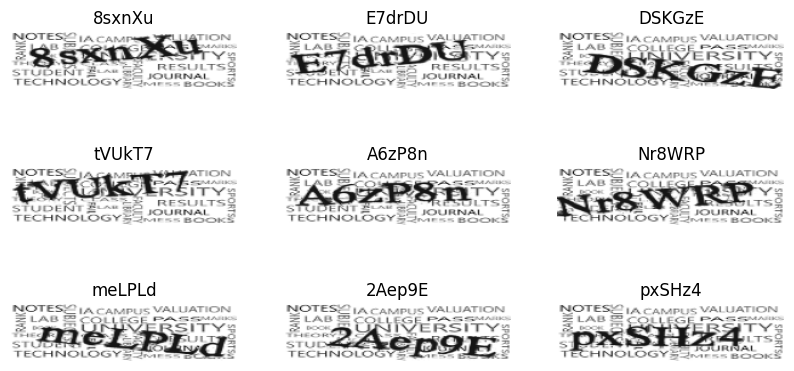

In [59]:
_, ax = plt.subplots(3, 3, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(9):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 3, i % 3].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 3, i % 3].set_title(label)
        ax[i // 3, i % 3].axis("off")
plt.show()

In [60]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [61]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
3/3 [==============================] - 19s 2s/step - loss: 112.8768 - val_loss: 42.3628
Epoch 2/100
3/3 [==============================] - 1s 376ms/step - loss: 36.9106 - val_loss: 28.3333
Epoch 3/100
3/3 [==============================] - 1s 358ms/step - loss: 26.6447 - val_loss: 30.3803
Epoch 4/100
3/3 [==============================] - 1s 367ms/step - loss: 27.9259 - val_loss: 31.4744
Epoch 5/100
3/3 [==============================] - 1s 358ms/step - loss: 28.3210 - val_loss: 30.5800
Epoch 6/100
3/3 [==============================] - 1s 369ms/step - loss: 27.3725 - val_loss: 28.8922
Epoch 7/100
3/3 [==============================] - 1s 407ms/step - loss: 26.0827 - val_loss: 27.5423
Epoch 8/100
3/3 [==============================] - 1s 380ms/step - loss: 25.3775 - val_loss: 27.1802
Epoch 9/100
3/3 [==============================] - 1s 369ms/step - loss: 25.4375 - val_loss: 27.2996
Epoch 10/100
3/3 [==============================] - 1s 369ms/step - loss: 25.5669 - val_loss

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

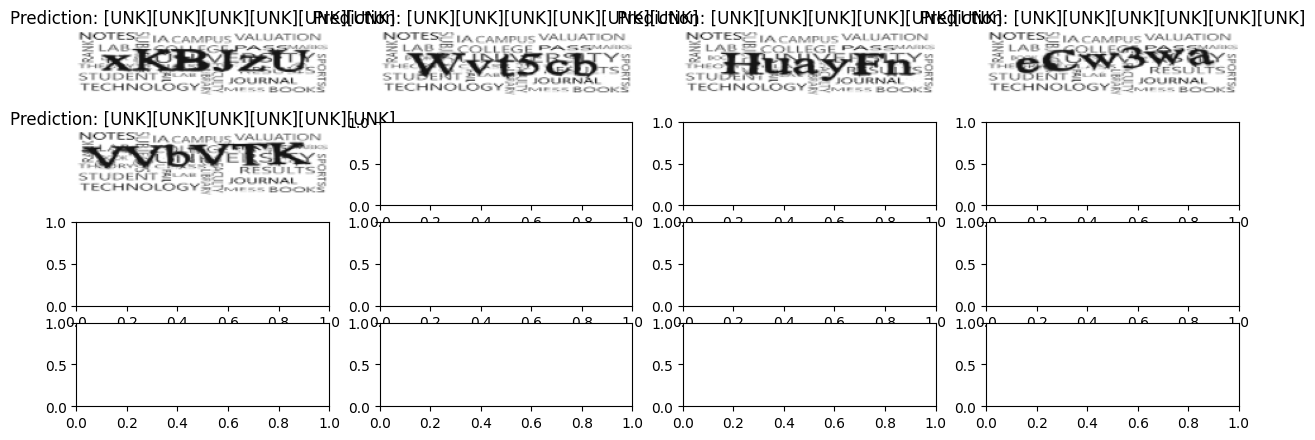

In [62]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [63]:
char_to_num.get_vocabulary()

['[UNK]',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'j',
 'k',
 'm',
 'n',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']